In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import copy
from fancyimpute import KNN 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
import joblib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [2]:
MIMIC_data = pd.read_csv('MIMIC_data_allbins.csv')
print('total row and columns in MIMIC data', MIMIC_data.shape)
print('total patient in the file ', MIMIC_data.icustay_id.value_counts().shape[0])

total row and columns in MIMIC data (397728, 82)
total patient in the file  22096


### Discretize action (There was some confusion on quartile range)

In [3]:
#geting the quartile only based on metavision for IV and Vassopressor 
vp_quartile = pd.qcut(MIMIC_data.loc[(MIMIC_data.dbsource=='metavision') &(MIMIC_data['max_VP']!=0)]['max_VP'], q=4)
vp_quartile_bins = [-float("inf"), 0.009, 0.11, 0.225, 0.451, float("inf")] # I have checke dand this is the bin 
#discreteze vassopressor action based on values 
vp_discrete = pd.cut(MIMIC_data.max_VP, bins = [-float("inf"), 0.009, 0.11, 0.225, 0.451, float("inf")], labels = [0, 1, 2, 3, 4])

##get quartile for IV data 
iv_quartile =  pd.qcut(MIMIC_data.loc[(MIMIC_data.dbsource=='metavision') &(MIMIC_data['total_IV']!=0)]['total_IV'], q=4)
iv_quartile_bins = [-float("inf"), 0, 100, 292, 753, float("inf")] # putting infinity to define lower and upper bound categories 
#discretize IV 
iv_discrete = pd.cut(MIMIC_data.total_IV, bins = [-float("inf"), 0, 100, 292, 753, float("inf")], labels = [0, 1, 2, 3, 4])

### discretize action space 
action = vp_discrete.cat.codes * 5 + iv_discrete.cat.codes

## Replace value in MIMIC dataset 
MIMIC_data['discrete_IV'] = iv_discrete.cat.codes
MIMIC_data['discrete_VP'] = vp_discrete.cat.codes
MIMIC_data['discrete_action'] = action.values


Text(0.5, 0, 'IV fluid dose (log)')

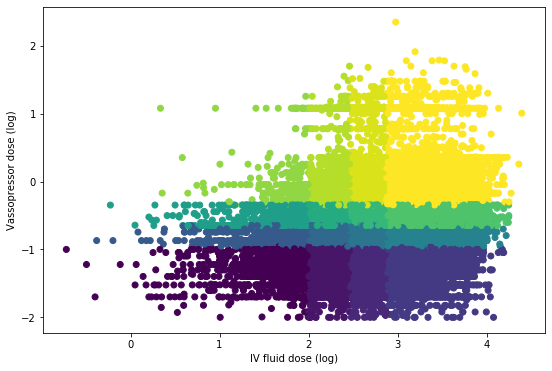

In [4]:
fig, ax = plt.subplots(figsize = (9, 6))
plt.scatter(np.log10(MIMIC_data.total_IV), np.log10(MIMIC_data.max_VP), c=MIMIC_data.discrete_action)
plt.ylabel('Vassopressor dose (log)')
plt.xlabel('IV fluid dose (log)')



### Removing low resolution patients data points 

In [5]:
#first get columns which contains missing value 
miss_values= MIMIC_data.isna().sum(axis=0).sort_values(ascending=False)
misscols = miss_values[miss_values>0].index
#filter 
MIMIC_data['Row_wise_missing'] = MIMIC_data[misscols].isna().sum(axis=1)/MIMIC_data[misscols].shape[1] * 100 #MIMIC_data.isna().sum(axis=1)/MIMIC_data.shape[1] * 100
#get miniumm traj % patient 
min_percent_missing_ptlist = MIMIC_data.loc[MIMIC_data.groupby('icustay_id')['Row_wise_missing'].idxmin()][['icustay_id','Row_wise_missing']]
discard_min_pt_list = min_percent_missing_ptlist[min_percent_missing_ptlist['Row_wise_missing']>20].icustay_id.tolist()
mean_NA_per_patient = MIMIC_data.groupby(['icustay_id'])['Row_wise_missing'].mean()
discard_mean_pt_list  = mean_NA_per_patient.index[mean_NA_per_patient>70].unique().tolist()
exclude_ptid_list = discard_min_pt_list+discard_mean_pt_list
print('total icustay to discard ', len(set(exclude_ptid_list)))
MIMIC_data = MIMIC_data[~MIMIC_data.icustay_id.isin(exclude_ptid_list)].drop(['Row_wise_missing'], axis=1).reset_index(drop=True)


total icustay to discard  4008


### Cap values and get cummulative balance

In [6]:

caps = pd.read_csv('capping_values.csv', sep=',',decimal='.')
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    for i in caps.index:
        param = caps.loc[i,'Parameter']
        maxval = caps.loc[i,'maxval']
        minval = caps.loc[i,'minval']
        #print(param,minval,maxval)
        MIMIC_data[param][MIMIC_data[param] >= maxval] = maxval
        MIMIC_data[param][MIMIC_data[param] <= minval] = minval

#calculate fluid balance by subtracting IV - UP 
MIMIC_data['cumm_fluid_balance'] = MIMIC_data['total_IV']-MIMIC_data['total_UP']
#MIMIC_data['cumm_fluid_balance'] = MIMIC_data.groupby("icustay_id")['cumm_fluid_balance'].shift(+1)
#MIMIC_data['cumm_fluid_balance'] = MIMIC_data['cumm_fluid_balance'].fillna(0)
## Recalculate BMI 
MIMIC_data['bmi'] = MIMIC_data.Weight / (MIMIC_data.Height/100)**2

# get only metavision data 
MIMIC_MVdata = MIMIC_data[MIMIC_data.dbsource=='metavision'].reset_index(drop=True)
## fixing action space asin MV only 21 actions exist 
# actual (fancy-ass) mapping function
mapping = [x for x in range(25) if x not in [5, 10, 15, 20]]
MIMIC_MVdata['discrete_action_original'] = MIMIC_MVdata['discrete_action'].copy()
# apply mapping
MIMIC_MVdata['discrete_action'] = MIMIC_MVdata['discrete_action'].apply(lambda x: mapping.index(x))
print('total patients in Metavision datset', MIMIC_MVdata.icustay_id.value_counts().shape[0])

total patients in Metavision datset 8002


#### Preparae a Evaluation set based on Carevue data 

In [7]:
# a testset based on carevue
#only select patinet who does not have 5,10, 15, 20 action space (just like MV data)
carevue_id_to_keep = MIMIC_data.loc[~MIMIC_data.discrete_action.isin([5,10,15,20]) & (MIMIC_data.dbsource=='carevue') ]['icustay_id'].value_counts()
evaluation_set = MIMIC_data[MIMIC_data.icustay_id.isin(carevue_id_to_keep[carevue_id_to_keep>=18].index)] 
## fix the action space 
# actual (fancy-ass) mapping function
mapping = [x for x in range(25) if x not in [5, 10, 15, 20]]
evaluation_set['discrete_action_original'] = evaluation_set['discrete_action'].copy()
# apply mapping
evaluation_set['discrete_action'] = evaluation_set['discrete_action'].apply(lambda x: mapping.index(x))
print('total patients in carevue evaluation set', evaluation_set.icustay_id.value_counts().shape[0])

total patients in carevue evaluation set 9811


#### Train test split data set using icustay as group 

In [8]:
gs_1 = GroupShuffleSplit(n_splits=1, train_size=.80, random_state=42)
train_ix, val_ix = next(gs_1.split(MIMIC_MVdata, groups=MIMIC_MVdata.icustay_id))
train_set = MIMIC_MVdata.iloc[train_ix].reset_index(drop=True)
val_set = MIMIC_MVdata.iloc[val_ix].reset_index(drop=True)
test_set = evaluation_set.copy()
#previously creted testset from MIMIC MV data 
#use this validation if you do not want to use tets set 
#validation_set = val_set.copy()
#gs_2 = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=42) # 50 % val 50% test
#val_ix, test_ix = next(gs_2.split(val_set, groups=val_set.icustay_id))
#test_set = val_set.iloc[test_ix].reset_index(drop=True)
#valset based on metavision split 
#val_set = val_set.iloc[val_ix].reset_index(drop=True)
train_ids = train_set.icustay_id.value_counts().shape[0]
val_ids = val_set.icustay_id.value_counts().shape[0]
test_ids = test_set.icustay_id.value_counts().shape[0]
print('Total patient in trainset is ', train_ids)
print('Total patient in validationset is ', val_ids)
print('Total patient in testset is ', test_ids)


Total patient in trainset is  6401
Total patient in validationset is  1601
Total patient in testset is  9811


In [9]:
# keep a raw data copy
train_rawdata = train_set.copy()
val_rawdata = val_set.copy()
test_rawdata = test_set.copy()

print(train_rawdata.shape)
print(val_rawdata.shape)
print(test_rawdata.shape)

(115218, 84)
(28818, 84)
(176598, 84)


#### All Features For Transformation (Normalization)

In [10]:
binary_fields = ['Gender','Ventilator', 'qsofa_gcs_score', 'qsofa_resprate_score', 'qsofa_sysbp_score']

norm_fields= ['Age','Weight','HeartRate','SYS','MAP','DIA','RespRate','Temp','FiO2',
    'Kalium','Natrium','Chloride','Glucose','Magnesium','Calcium','ANION_GAP',
    'HB','LEU','Trombo','APTT','Art_PH','PaO2','PaCO2','Height',
    'Art_BE','Bicarbonaat','Lactate','Sofa_score','Sirs_score','Shock_Index',
    'PF_ratio','Albumine', 'Ion_Ca', 
    'mingcs', 'lods', 'elixhauser', 'cumm_fluid_balance', 'bmi', 'qsofa'] 
log_fields = ['max_VP_prev','SpO2','Ureum','Creat','ALAT','ASAT','Bili','INR',
              'Running_total_IV','total_IV_prev','Running_total_UP','total_UP']

not_used = ['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
            'interval_end_time', 'Reward',
             'Discharge', 'discrete_action','total_IV','max_VP', 
             'morta_90', 'morta_hosp',  're_admission', 
              'composite_outcome', 'action', 'dbsource', 'exclude',
              'blood_culture_positive', 'metastatic_cancer',
              'race_black', 'race_hispanic', 'race_other', 'race_white',
              're_admission', 'elixhauser_hospital',
               'BANDS', 'diabetes', 'discrete_IV', 'discrete_VP', 'discrete_action_original']

              


In [11]:
# normalise binary fields
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    train_set[binary_fields] = train_set[binary_fields] - 0.5 
    val_set[binary_fields] = val_set[binary_fields] - 0.5 
    test_set[binary_fields] = test_set[binary_fields] - 0.5
    print("done")

done


In [12]:
# normal distn fields
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    for item in norm_fields:
        av = train_set[item].mean()
        std = train_set[item].std()
        train_set[item] = (train_set[item] - av) / std
        val_set[item] = (val_set[item] - av) / std
        test_set[item] = (test_set[item] - av) / std
        #print(item,av.round(3),std.round(3))

In [13]:
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    # log normal fields
    train_set[log_fields] = np.log(0.1 + train_set[log_fields])
    val_set[log_fields] = np.log(0.1 + val_set[log_fields])
    test_set[log_fields] = np.log(0.1 + test_set[log_fields])
    
    for item in log_fields:
        av = train_set[item].mean()
        std = train_set[item].std()
        train_set[item] = (train_set[item] - av) / std
        val_set[item] = (val_set[item] - av) / std
        test_set[item] = (test_set[item] - av) / std
        #print(item,av.round(3),std.round(3))

In [14]:
import copy
# scale all features
scalable_fields = copy.deepcopy(binary_fields)
scalable_fields.extend(norm_fields)
scalable_fields.extend(log_fields)

# min-max normalization
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    for col in scalable_fields:
        minimum = np.nanmin(train_set[col])
        maximum = np.nanmax(train_set[col])
        #print(col,minimum,maximum)
        train_set[col] = (train_set[col] - minimum)/(maximum-minimum)
        val_set[col] = (val_set[col] - minimum)/(maximum-minimum)
        test_set[col] = (test_set[col] - minimum)/(maximum-minimum)

### Impute Data with KNN

In [15]:
#training imputation
train_unique_ids = train_set['icustay_id'].unique()
train_before_impute = train_set.head(30)
for unique_id in train_unique_ids:
    X_incomplete = train_set.loc[train_set['icustay_id']==unique_id][binary_fields+norm_fields+log_fields]
    pd.reset_option('mode.chained_assignment')
    with pd.option_context('mode.chained_assignment', None):
        train_set.loc[train_set['icustay_id']==unique_id,binary_fields+norm_fields+log_fields] = KNN(k=3,verbose=False).fit_transform(X_incomplete) # XX_filled_knn
print("done")
train_set_after_impute = train_set.head(30)

c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


done


#### validation imputation

In [16]:
val_unique_ids = val_set['icustay_id'].unique()
val_before_impute = val_set.head(30)
for unique_id in val_unique_ids:
    X_incomplete = val_set.loc[val_set['icustay_id']==unique_id][binary_fields+norm_fields+log_fields]
    pd.reset_option('mode.chained_assignment')
    with pd.option_context('mode.chained_assignment', None):
        val_set.loc[val_set['icustay_id']==unique_id,binary_fields+norm_fields+log_fields] = KNN(k=3,verbose=False).fit_transform(X_incomplete) # XX_filled_knn
print("done")
val_after_impute = val_set.head(30)

c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


done


#### Test set imputation 

In [17]:
test_unique_ids = test_set['icustay_id'].unique()
test_before_impute = test_set.head(30)
for unique_id in test_unique_ids:
    X_incomplete = test_set.loc[test_set['icustay_id']==unique_id][binary_fields+norm_fields+log_fields]
    pd.reset_option('mode.chained_assignment')
    with pd.option_context('mode.chained_assignment', None):
        test_set.loc[test_set['icustay_id']==unique_id,binary_fields+norm_fields+log_fields] = KNN(k=3,verbose=False).fit_transform(X_incomplete) # XX_filled_knn
print("done")
test_after_impute = test_set.head(30)

c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


done


In [18]:
total_train_ids = train_set.icustay_id.value_counts().shape[0]
total_test_ids = test_set.icustay_id.value_counts().shape[0]
total_val_ids = val_set.icustay_id.value_counts().shape[0]
print('Total patient in trainset is ', total_train_ids, ' total states ', train_set.shape[0])
print('Total patient in testset is ', total_test_ids, ' total states', test_set.shape[0])
print('Total patient in valset is ', total_val_ids, ' total states', val_set.shape[0])

Total patient in trainset is  6401  total states  115218
Total patient in testset is  9811  total states 176598
Total patient in valset is  1601  total states 28818


c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### adding state and next_state

In [19]:
def add_state_next_state_id(df):
    ''' this will add row_id and next_row id'''
    df = df.reset_index(drop=True)
    df['row_id'] = df.index
    df['row_id_next'] = np.where(df['icustay_id'].shift(-1) !=df['icustay_id'],
                                 df['row_id'], df['row_id']+1)
    df['row_id_next'][0] = 1
    df['row_id_next'].iloc[-1] = df['row_id'].iloc[-1]
    return df    




c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#add state id 
train_set = add_state_next_state_id(train_set)
val_set = add_state_next_state_id(val_set)
test_set = add_state_next_state_id(test_set)


c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

### Feature list based on lucas studies 

In [21]:
luca_features = ['Gender','Ventilator', #binary features
                'Age','Weight','HeartRate','SYS','MAP','DIA','RespRate','Temp','FiO2',
                 'Kalium','Natrium','Chloride','Glucose','Magnesium','Calcium','ANION_GAP',
                 'HB','LEU','Trombo','APTT','Art_PH','PaO2','PaCO2','Height',
                 'Art_BE','Bicarbonaat','Lactate','Sofa_score','Sirs_score','Shock_Index',
                 'PF_ratio','Albumine', 'Ion_Ca', # normal. features
                'max_VP_prev','SpO2','Ureum','Creat','ALAT','ASAT','Bili','INR', #logfeatures
                'Running_total_IV','total_IV_prev','Running_total_UP','total_UP']

c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Features extension based on supervised model 

In [27]:
#feature_names = binary_fields+norm_fields+log_fields
def create_RL_data_dict(feature_names=luca_features):
    print('total feature to include in RL model is ', len(feature_names))
    #sort the feature IDs 
    feature_names = np.sort(np.array(feature_names))

    feature_df_train = train_set[feature_names]
    feature_df_val = val_set[feature_names]
    feature_df_test = test_set[feature_names]

    v = DictVectorizer(sparse = False)
    feature_dict_train = feature_df_train.to_dict('records')
    feature_dict_val = feature_df_val.to_dict('records')
    feature_dict_test = feature_df_test.to_dict('records')

    X_train = v.fit_transform(feature_dict_train)
    X_val = v.transform(feature_dict_val)
    X_test = v.transform(feature_dict_test)

    reward_train = train_set.Reward.values
    reward_val = val_set.Reward.values
    reward_test = test_set.Reward.values

    action_train = train_set.discrete_action.values
    action_val = val_set.discrete_action.values
    action_test = test_set.discrete_action.values

    state_row_id_train       = [int(x) for x in train_set.row_id.values]
    next_state_row_id_train  = [int(x) for x in  train_set.row_id_next.values]

    state_row_id_val         = [int(x) for x in val_set.row_id.values]
    next_state_row_id_val    = [int(x) for x in val_set.row_id_next.values]

    state_row_id_test        = [int(x) for x in test_set.row_id.values]
    next_state_row_id_test   = [int(x) for x in test_set.row_id_next.values]

    output_dict = {'train' : {
                        'X' : X_train,
                        'action' : action_train,
                        'reward' : reward_train,
                        'state_id' : state_row_id_train,
                        'next_state_id' : next_state_row_id_train
                    },
                    'val' : {
                        'X' : X_val,
                        'action' : action_val,
                        'reward' : reward_val,
                        'state_id' : state_row_id_val,
                        'next_state_id' : next_state_row_id_val
                    },
                'test' : {
                        'X' : X_test,
                        'action' : action_test,
                        'reward' : reward_test,
                        'state_id' : state_row_id_test,
                        'next_state_id' : next_state_row_id_test
                    },
                'v' : v,
                'featurenames': np.sort(np.array(list(feature_dict_train[1].keys())))
         }

    print(len(feature_dict_train))
    print(len(output_dict['train']['next_state_id']))
    print(len(output_dict['val']['next_state_id']))
    print(len(output_dict['test']['next_state_id']))
    print(output_dict['featurenames'])
    #print(feature_names)
    return output_dict

c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Write Data for default state space (based on Lucas research)

In [28]:
## Get data dict for luca features and extended features 
data_dict_luca = create_RL_data_dict(luca_features)

c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


total feature to include in RL model is  47
115218
115218
28818
176598
['ALAT' 'ANION_GAP' 'APTT' 'ASAT' 'Age' 'Albumine' 'Art_BE' 'Art_PH'
 'Bicarbonaat' 'Bili' 'Calcium' 'Chloride' 'Creat' 'DIA' 'FiO2' 'Gender'
 'Glucose' 'HB' 'HeartRate' 'Height' 'INR' 'Ion_Ca' 'Kalium' 'LEU'
 'Lactate' 'MAP' 'Magnesium' 'Natrium' 'PF_ratio' 'PaCO2' 'PaO2'
 'RespRate' 'Running_total_IV' 'Running_total_UP' 'SYS' 'Shock_Index'
 'Sirs_score' 'Sofa_score' 'SpO2' 'Temp' 'Trombo' 'Ureum' 'Ventilator'
 'Weight' 'max_VP_prev' 'total_IV_prev' 'total_UP']


### create experiment folder 

In [ ]:
#os.mkdir('Luca_experiment')
#os.mkdir('Extended_experiment')

    


### Write prepared data in specific folders 

In [29]:
# Save raw data to csv files
train_rawdata.to_csv('commondata/train_rawdata.csv', index=False)
val_rawdata.to_csv('commondata/val_rawdata.csv', index=False)
test_rawdata.to_csv('commondata/test_rawdata.csv', index=False)

# Save processed data to csv files
train_set.to_csv('commondata/train_data_scaled_imputed.csv', index=False)
val_set.to_csv('commondata/val_data_scaled_imputed.csv', index=False)
test_set.to_csv('commondata/test_data_scaled_imputed.csv', index=False)

# Save Pickle for modelling
joblib.dump(data_dict_luca, os.path.join('Luca_experiment/', 'data/Luca_data_dict.pkl'))
pd.Series(luca_features).to_csv(os.path.join('Luca_experiment/', 'data/luca_features.csv'), index=False)


c:\Users\gmpxe\Anaconda3\envs\rlenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Part 2 : Prepare Data for Extended space

In [1]:
# Import required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import copy
from fancyimpute import KNN 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
import joblib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")


In [2]:
### copy the create_dict function from Part1- or above ( I am running this part another day)
#feature_names = binary_fields+norm_fields+log_fields
def create_RL_data_dict(feature_names):
    print('total feature to include in RL model is ', len(feature_names))
    #sort the feature IDs 
    feature_names = np.sort(np.array(feature_names))

    feature_df_train = train_set[feature_names]
    feature_df_val = val_set[feature_names]
    feature_df_test = test_set[feature_names]

    v = DictVectorizer(sparse = False)
    feature_dict_train = feature_df_train.to_dict('records')
    feature_dict_val = feature_df_val.to_dict('records')
    feature_dict_test = feature_df_test.to_dict('records')

    X_train = v.fit_transform(feature_dict_train)
    X_val = v.transform(feature_dict_val)
    X_test = v.transform(feature_dict_test)

    reward_train = train_set.Reward.values
    reward_val = val_set.Reward.values
    reward_test = test_set.Reward.values

    action_train = train_set.discrete_action.values
    action_val = val_set.discrete_action.values
    action_test = test_set.discrete_action.values

    state_row_id_train       = [int(x) for x in train_set.row_id.values]
    next_state_row_id_train  = [int(x) for x in  train_set.row_id_next.values]

    state_row_id_val         = [int(x) for x in val_set.row_id.values]
    next_state_row_id_val    = [int(x) for x in val_set.row_id_next.values]

    state_row_id_test        = [int(x) for x in test_set.row_id.values]
    next_state_row_id_test   = [int(x) for x in test_set.row_id_next.values]

    output_dict = {'train' : {
                        'X' : X_train,
                        'action' : action_train,
                        'reward' : reward_train,
                        'state_id' : state_row_id_train,
                        'next_state_id' : next_state_row_id_train
                    },
                    'val' : {
                        'X' : X_val,
                        'action' : action_val,
                        'reward' : reward_val,
                        'state_id' : state_row_id_val,
                        'next_state_id' : next_state_row_id_val
                    },
                'test' : {
                        'X' : X_test,
                        'action' : action_test,
                        'reward' : reward_test,
                        'state_id' : state_row_id_test,
                        'next_state_id' : next_state_row_id_test
                    },
                'v' : v,
                'featurenames': np.sort(np.array(list(feature_dict_train[1].keys())))
         }

    print(len(feature_dict_train))
    print(len(output_dict['train']['next_state_id']))
    print(len(output_dict['val']['next_state_id']))
    print(len(output_dict['test']['next_state_id']))
    print(output_dict['featurenames'])
    #print(feature_names)
    return output_dict

### List of extended space features
- luca's features ( default state )
- + 6 features from supervised model


In [4]:
### features selected from supervised model to increase lucas state space 
# 6 features selected to increase the state space : 'qsofa_gcs_score',  'qsofa_sysbp_score', #extended_binary
               # 'mingcs', 'lods', 'elixhauser', 'cumm_fluid_balance'

extended_features  = ['Gender','Ventilator', #binary features
                  'Age','Weight','HeartRate','SYS','MAP','DIA','RespRate','Temp','FiO2',
                 'Kalium','Natrium','Chloride','Glucose','Magnesium','Calcium','ANION_GAP',
                 'HB','LEU','Trombo','APTT','Art_PH','PaO2','PaCO2','Height',
                 'Art_BE','Bicarbonaat','Lactate','Sofa_score','Sirs_score','Shock_Index',
                 'PF_ratio','Albumine', 'Ion_Ca', # normal. features
                'max_VP_prev','SpO2','Ureum','Creat','ALAT','ASAT','Bili','INR', #logfeatures
                'Running_total_IV','total_IV_prev','Running_total_UP','total_UP', 
                 'qsofa_gcs_score',  'qsofa_sysbp_score', #extended_binary
                'mingcs', 'lods', 'elixhauser', 'cumm_fluid_balance' ] # extended_normal 

print('total number of features in the extended space model', len(extended_features))

total number of features in the extended space model 53


##### We already have scaled and imputed features so we do not need to re-run th ewhole thing 

In [5]:
### Read the Csv file from Part1 code (Default space data preparation)
train_set = pd.read_csv('commondata/train_data_scaled_imputed.csv')
val_set = pd.read_csv('commondata/val_data_scaled_imputed.csv')
test_set = pd.read_csv('commondata/test_data_scaled_imputed.csv')


In [7]:
print('total ids in trainset ', train_set.icustay_id.unique().shape[0])
print('total ids in valset ', val_set.icustay_id.unique().shape[0])
print('total ids in testset ', test_set.icustay_id.unique().shape[0]) # only carevue patients

total ids in trainset  6401
total ids in valset  1601
total ids in testset  9811


### Write data based on supervised extended state space 

In [8]:
#write results for extended features
data_dict_extend = create_RL_data_dict(extended_features)
joblib.dump(data_dict_extend, os.path.join('Extended_experiment/', 'data/Extended_data_dict.pkl'))
pd.Series(extended_features).to_csv(os.path.join('Extended_experiment/', 'data/extended_features.csv'), index=False)

total feature to include in RL model is  53
115218
115218
28818
176598
['ALAT' 'ANION_GAP' 'APTT' 'ASAT' 'Age' 'Albumine' 'Art_BE' 'Art_PH'
 'Bicarbonaat' 'Bili' 'Calcium' 'Chloride' 'Creat' 'DIA' 'FiO2' 'Gender'
 'Glucose' 'HB' 'HeartRate' 'Height' 'INR' 'Ion_Ca' 'Kalium' 'LEU'
 'Lactate' 'MAP' 'Magnesium' 'Natrium' 'PF_ratio' 'PaCO2' 'PaO2'
 'RespRate' 'Running_total_IV' 'Running_total_UP' 'SYS' 'Shock_Index'
 'Sirs_score' 'Sofa_score' 'SpO2' 'Temp' 'Trombo' 'Ureum' 'Ventilator'
 'Weight' 'cumm_fluid_balance' 'elixhauser' 'lods' 'max_VP_prev' 'mingcs'
 'qsofa_gcs_score' 'qsofa_sysbp_score' 'total_IV_prev' 'total_UP']


### Shaped reward implementation as per Raghu but we are not using it 

In [ ]:
c0 = -0.25
c1 = -0.75
c2 = -0.5

In [ ]:
def get_shaped_reward(df):
    df['shaped_reward'] = 0 
    for i in df.index:
        if i == 0:
            continue
        if df.loc[i, 'icustay_id'] == df.loc[i-1, 'icustay_id']:
            sofa_cur = df.loc[i,'Sofa_score']
            sofa_prev = df.loc[i-1,'Sofa_score']
            lact_cur = df.loc[i,'Lactate']
            lact_prev = df.loc[i-1,'Lactate']
            reward = 0
            if sofa_cur == sofa_prev and sofa_cur != 0:
                reward += c0
                reward += c1*(sofa_cur-sofa_prev)
                reward += c2*np.tanh(lact_cur - lact_prev)
                df.loc[i-1,'shaped_reward'] = reward
        '''if i % 10000 == 0:
            print(i)'''
    return df


In [ ]:
test = get_shaped_reward(df=test_set.copy())